## 导入包

In [1]:
import jieba
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd

## 加载数据
读取之后可以先获取数据的长度、数量、形状或列出几个数据

In [8]:
# 加载数据 delimiter 分隔符
train_data = pd.read_csv('data/train.csv', delimiter='\t', names=['text', 'label'])    # 读取训练数据
test_data = pd.read_csv('data/test.csv', delimiter='\t', names=['text'])      # 读取测试数据

print (train_data.shape)
train_data.head()

(12100, 2)


,text,label
0,还有双鸭山到淮阴的汽车票吗13号的,Travel-Query
1,从这里怎么回家,Travel-Query
2,随便播放一首专辑阁楼里的佛里的歌,Music-Play
3,给看一下墓王之王嘛,FilmTele-Play
4,我想看挑战两把s686打突变团竞的游戏视频,Video-Play


In [3]:
train_data['label'].value_counts()

label
FilmTele-Play            1355
Video-Play               1334
Music-Play               1304
Radio-Listen             1285
Alarm-Update             1264
Weather-Query            1229
Travel-Query             1220
HomeAppliance-Control    1215
Calendar-Query           1214
TVProgram-Play            240
Audio-Play                226
Other                     214
Name: count, dtype: int64

In [9]:
import statistics

text_lengths = [len(text) for text in train_data['text']]
# text_lengths_jieba = [len(jieba.lcut(text)) for text in train_data['text']]

print (min(text_lengths), max(text_lengths), statistics.mean(text_lengths), statistics.mode(text_lengths))


4 54 15.138677685950412 14


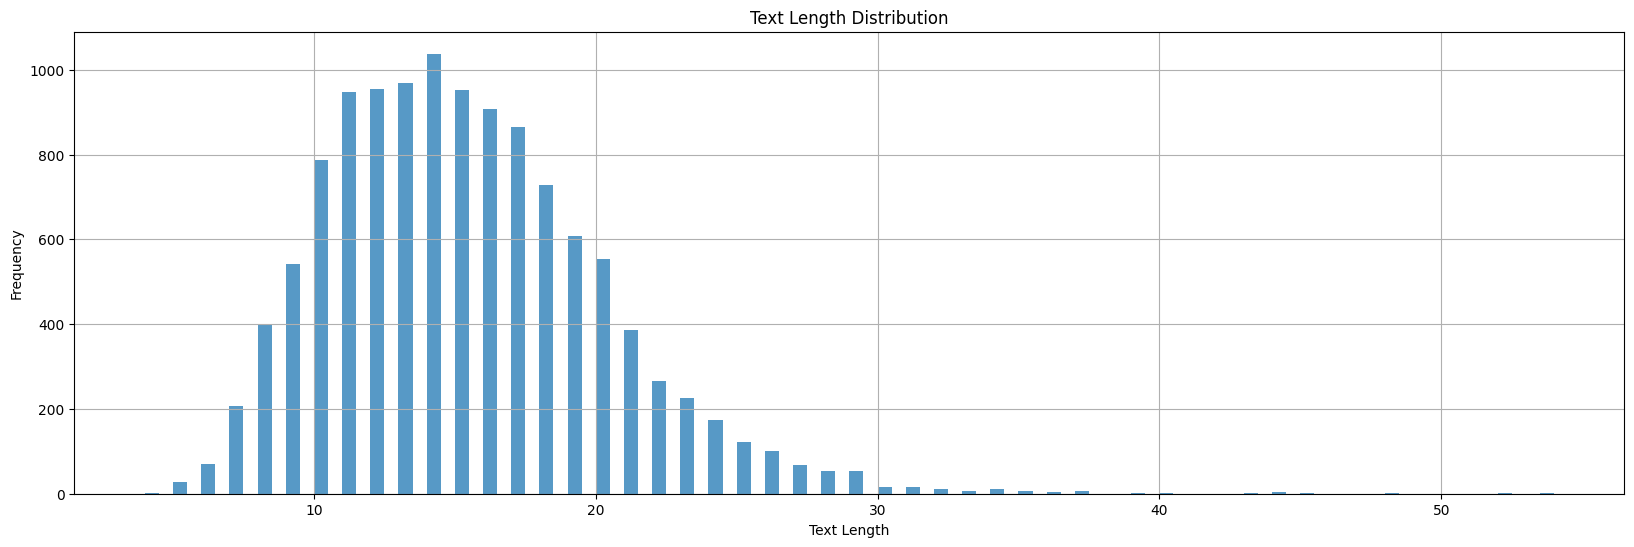

In [10]:
import matplotlib.pyplot as plt

# 创建一个新的图形，设置图形的尺寸
plt.figure(figsize=(20, 6))

# 使用 hist 函数绘制直方图
plt.hist(text_lengths, bins=100, density=False, alpha=0.75)

# 设置 x 轴标签
plt.xlabel('Text Length')

# 设置 y 轴标签
plt.ylabel('Frequency')

# 设置图表标题
plt.title('Text Length Distribution')

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

## 分词、词典、词袋、TFIDF

In [25]:
import os
import jieba
import numpy as np
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel
from tqdm import tqdm

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### split_words

In [6]:
def split_words(doc):
    # 定义分词函数 用strip()方法去除字符串doc开头和结尾的空白字符
    words = jieba.lcut(doc.strip("\ufeff").strip())
    return words

### Dictionary

In [7]:
docs = []

for document in tqdm(train_data['text']):
    try:
        docs.append(split_words(document))
    except Exception as e:
        print(document, "异常:", e)

# 使用gensim库中的Dictionary类创建一个词汇表
dct = Dictionary(docs)

# 获取当前工作目录的路径
base_path = os.getcwd()

# 将输出目录设置为当前工作目录下的data文件夹
output_dir = os.path.join(base_path, "data")

# 将词汇表保存为文本文件，文件名为dict.txt，存储在output_dir指定的目录中
dct.save_as_text(os.path.join(output_dir , "dict.txt"))

  0%|          | 0/12100 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\五行缺钱\AppData\Local\Temp\jieba.cache
Loading model cost 0.385 seconds.
Prefix dict has been built successfully.
100%|██████████| 12100/12100 [00:00<00:00, 13452.47it/s]


In [9]:
len(dct)

11145

In [10]:
# dct.token2id 是 Dictionary 对象的一个属性，它是一个字典，其中键是词汇表中的单词（token），值是对应的唯一整数ID
dct.token2id

{'13': 0,
 '到': 1,
 '双鸭山': 2,
 '号': 3,
 '吗': 4,
 '汽车票': 5,
 '淮阴': 6,
 '的': 7,
 '还有': 8,
 '从': 9,
 '回家': 10,
 '怎么': 11,
 '这里': 12,
 '一首': 13,
 '专辑': 14,
 '佛里': 15,
 '播放': 16,
 '歌': 17,
 '里': 18,
 '阁楼': 19,
 '随便': 20,
 '一下': 21,
 '嘛': 22,
 '墓': 23,
 '王之王': 24,
 '看': 25,
 '给': 26,
 's686': 27,
 '两把': 28,
 '团': 29,
 '想': 30,
 '我': 31,
 '打': 32,
 '挑战': 33,
 '游戏': 34,
 '突变': 35,
 '竞': 36,
 '视频': 37,
 '上': 38,
 '和平': 39,
 '必备': 40,
 '战神': 41,
 '技巧': 42,
 '精英': 43,
 '2019': 44,
 '古装': 45,
 '小女': 46,
 '年': 47,
 '爱情': 48,
 '电视剧': 49,
 '花不弃': 50,
 '花絮': 51,
 '2004': 52,
 '一个': 53,
 '一会': 54,
 '剧给': 55,
 '呢': 56,
 '找': 57,
 '推理': 58,
 '去': 59,
 '啊': 60,
 '地方': 61,
 '深圳': 62,
 '经过': 63,
 '自驾游': 64,
 '那些': 65,
 '都': 66,
 '乒乓球': 67,
 '今天': 68,
 '女子双打': 69,
 '比赛': 70,
 '现场': 71,
 '转播': 72,
 '催眠': 73,
 '单曲': 74,
 '吧': 75,
 '循环': 76,
 '你': 77,
 '导演': 78,
 '悬疑剧': 79,
 '曹盾': 80,
 '能': 81,
 '新闻台': 82,
 '新闻广播': 83,
 '是': 84,
 '河南': 85,
 '交通': 86,
 '广播电台': 87,
 '来': 88,
 '武汉': 89,
 '类': 90,
 '王菲': 91,
 '经典音乐

### corpus

In [8]:
# 词袋法构建 dct.doc2bow(line) 将每个文档转换为词袋模型
corpus = [dct.doc2bow(line) for line in docs]
print (len(corpus))
print (corpus[0])

12100
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1)]


In [12]:
dct[7]

'的'

### TfidfModel

In [9]:
# TFIDF模型构建
model = TfidfModel(corpus=corpus)
model.save(os.path.join(output_dir , "tfidf.pkl"))

TFIDF之后没有按原文的词顺序进行，只是按词典编号的顺序给出的tfidf value

In [10]:
for idx, values in model[corpus[0]]:
    print (idx, values)

0 0.3353866385671328
1 0.18562563151910624
2 0.5127355082373827
3 0.19123403801691757
4 0.1268695739446306
5 0.35432965217827916
6 0.5805834833084199
7 0.06565636391562794
8 0.2656265018239661


In [15]:
for idx, value in model[corpus[0]]:
    print(f"{dct[idx]}: {value}")

13: 0.3353866385671328
到: 0.18562563151910624
双鸭山: 0.5127355082373827
号: 0.19123403801691757
吗: 0.1268695739446306
汽车票: 0.35432965217827916
淮阴: 0.5805834833084199
的: 0.06565636391562794
还有: 0.2656265018239661


In [16]:
docs[0]

['还有', '双鸭山', '到', '淮阴', '的', '汽车票', '吗', '13', '号', '的']

In [17]:
[dct.token2id[token] for token in docs[0]]

[8, 2, 1, 6, 7, 5, 4, 0, 3, 7]

In [18]:
tfidf_value = dict(model[corpus[0]])
print (tfidf_value)
tfidf_value[7]

{0: 0.3353866385671328, 1: 0.18562563151910624, 2: 0.5127355082373827, 3: 0.19123403801691757, 4: 0.1268695739446306, 5: 0.35432965217827916, 6: 0.5805834833084199, 7: 0.06565636391562794, 8: 0.2656265018239661}


0.06565636391562794

In [19]:
tfidf_value = dict(model[corpus[100]])
print (tfidf_value)
tfidf_value[7]

{4: 0.11988659917758103, 7: 0.031021299825778337, 232: 0.16835128568938457, 356: 0.2458987484606706, 398: 0.21937347901468723, 445: 0.5486278324139209, 446: 0.42727433055210157, 447: 0.5486278324139209, 448: 0.2513632004984258}


0.031021299825778337

In [20]:
[dict(model[corpus[0]])[dct.token2id[token]] for token in docs[0]]

[0.2656265018239661,
 0.5127355082373827,
 0.18562563151910624,
 0.5805834833084199,
 0.06565636391562794,
 0.35432965217827916,
 0.1268695739446306,
 0.3353866385671328,
 0.19123403801691757,
 0.06565636391562794]

In [12]:
train_tfidf = []
for i in range(len(corpus)):
    train_tfidf.append([dict(model[corpus[i]])[dct.token2id[token]] for token in docs[i]])

train_tfidf[:2]

[[0.2656265018239661,
  0.5127355082373827,
  0.18562563151910624,
  0.5805834833084199,
  0.06565636391562794,
  0.35432965217827916,
  0.1268695739446306,
  0.3353866385671328,
  0.19123403801691757,
  0.06565636391562794],
 [0.42743292899105567,
  0.5813629201565121,
  0.38299376312560907,
  0.5767443313012319]]

In [22]:
train_data['label'].values

array(['Travel-Query', 'Travel-Query', 'Music-Play', ..., 'Radio-Listen',
       'Video-Play', 'Alarm-Update'], dtype=object)

## train_dataset & train_loader

In [14]:
labels = train_data['label'].values

# 标签编码
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(train_tfidf, encoded_labels, test_size=0.2, random_state=42)

# 创建数据加载器
class TextDataset(Dataset):
    # 填充标记的索引 PAD_IDX，
    # X: 特征数据（x 可以是文本经过分词、编码后的数值表示）
    # Y: 标签数据（每个标签都对应一个索引）
    def __init__(self, X, y, pad_token_idx=0):
        self.PAD_IDX = pad_token_idx
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], len(self.X[idx])

    # 将不同长度的文本序列填充到相同的长度，以便可以作为一个批次输入到模型中
    def collate_fn(self, batch):
        """
        数据聚合
        :param batch: list列表，列表中的每个元素都是调用了dataset的__getitem__方法得到的
        :return:
        """
        # 这行代码将 batch 中的样本按照特征 x、标签 y 和长度 lengths 分别打包。zip(*batch) 会将 batch 中的元组分组，然后 list 将这些分组转换成列表
        x, y, lengths = list(zip(*batch))
        max_length = max(lengths)
        for i in range(len(x)):
            x[i].extend([self.PAD_IDX] * (max_length - lengths[i]))  # 数据填充

        x = torch.tensor(x, dtype=torch.float32)  # [N,T]
        y = torch.tensor(y, dtype=torch.long)  # [N,]
        return x, y

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)


train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, collate_fn=val_dataset.collate_fn)


DataLoader 是 PyTorch 中用于封装数据集并提供批量加载数据功能的一个类

train_dataset：这是传递给 DataLoader 的数据集对象，它应该是一个继承自 Dataset 类的实例，这里就是之前定义的 TextDataset 类的实例，包含了训练数据的特征和标签。

batch_size=3：指定每个批次（batch）的大小为3，意味着每次从数据集中取出3个样本进行训练。
 
shuffle=True：表示在每个epoch开始时，数据将被打乱。这有助于模型学习时的泛化能力，因为它确保了模型不会对数据集中的特定顺序产生依赖。
 
collate_fn=train_dataset.collate_fn：指定了自定义的 collate_fn 函数，这个函数定义了如何将多个样本数据组合成一个批次。
在这里，它负责将不同长度的文本序列填充到相同的长度，并转换为 PyTorch 张量

在文本处理中，x 作为文本经过分词和编码后的数值表示，确实代表了文本的内容，但它仍然需要进行填充（padding）处理，原因如下：

### 统一批次大小：

在使用深度学习模型时，输入数据需要具有统一的维度。这意味着在一个批次（batch）中的所有样本必须具有相同的序列长度，以便能够作为一个整体输入到模型中。
填充是确保不同长度的序列能够被整合到一个固定大小的批次中的一种方法。

### 模型结构要求：

许多模型结构，特别是循环神经网络（RNN）和其变体（如LSTM和GRU），以及Transformer模型，都是基于序列的。这些模型在处理输入时需要固定长度的序列，以便在每个时间步长上应用相同的权重。
填充使得所有序列达到相同的长度，从而满足这些模型的结构要求。

### 计算效率：

在GPU或TPU上进行并行计算时，统一的批次大小可以提高计算效率。如果序列长度不一致，可能会导致某些计算资源的浪费，因为不同长度的序列需要不同的处理时间。

### 掩码（Masking）：

在处理填充序列时，通常还需要使用掩码（masking）来告诉模型哪些部分是实际的文本内容，哪些部分是填充的。这对于模型正确理解输入数据非常重要，尤其是在注意力机制（如Transformer模型）中。
批处理和内存管理：

填充可以帮助优化内存使用和数据传输。没有填充的情况下，不同长度的序列可能会导致内存使用不均匀，影响数据加载和处理的速度。
因此，尽管x已经是文本的数值表示，填充仍然是必要的步骤，以确保数据能够被有效地处理和输入到模型中。填充不仅关系到模型的输入要求，还关系到训练过程中的计算效率和模型性能。

In [15]:
# 迭代器 获取下一个批次的数据
data_iter = iter(train_loader)
inputs, labels = next(data_iter)
inputs, labels 

(tensor([[0.3733, 0.6655, 0.4376, 0.0376, 0.2738, 0.3243, 0.2114, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.5164, 0.0870, 0.3847, 0.3769, 0.0870, 0.3561, 0.3291, 0.2572, 0.2098,
          0.2495, 0.1681],
         [0.2690, 0.5274, 0.1958, 0.3312, 0.2364, 0.2883, 0.2364, 0.1686, 0.5274,
          0.0000, 0.0000]]),
 tensor([5, 5, 4]))

In [25]:
inputs.shape

torch.Size([3, 10])

In [26]:
len(train_dataset)

9680

## IntentClassifier

In [16]:
import torch.nn as nn

class IntentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(IntentClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

input_dim = 1  # 每个时间步的输入维度（TF-IDF值）
hidden_dim = 16  # LSTM隐藏层的维度
output_dim = train_data['label'].nunique()  # 输出类别数,12

model = IntentClassifier(input_dim, hidden_dim, output_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
train_data['label'].nunique()

12

## 模型训练

In [18]:
from sklearn.metrics import accuracy_score
from torch import optim

# 优化损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
loss_list = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(-1))  # 增加一个维度以匹配输入要求
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_list.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


    # 模型评估
    with torch.no_grad():
        model.eval()
        y_preds = []
        y_trues = []
        bar = tqdm(val_loader)
        for inputs, labels in bar:
            outputs = model(inputs.unsqueeze(-1))
            # scores = model(x)  # 获取模型前向预测结果 [N,num_classes]
            y_pred = torch.argmax(outputs, dim=1)  # [N,]
            y_trues.append(labels)
            y_preds.append(y_pred)
        y_preds = torch.concat(y_preds, dim=0).numpy()
        y_trues = torch.concat(y_trues, dim=0).numpy()
        accuracy = accuracy_score(y_trues, y_preds)
        print(f'Epoch [{epoch+1}/{num_epochs}], eval accuracy: {accuracy:.4f}')

Epoch [1/30], Loss: 2.4655


100%|██████████| 807/807 [00:01<00:00, 681.13it/s]


Epoch [1/30], eval accuracy: 0.1194
Epoch [2/30], Loss: 2.4384


100%|██████████| 807/807 [00:01<00:00, 460.20it/s]


Epoch [2/30], eval accuracy: 0.1583
Epoch [3/30], Loss: 2.4280


100%|██████████| 807/807 [00:01<00:00, 504.96it/s]


Epoch [3/30], eval accuracy: 0.1653
Epoch [4/30], Loss: 2.4258


100%|██████████| 807/807 [00:01<00:00, 514.86it/s]


Epoch [4/30], eval accuracy: 0.1682
Epoch [5/30], Loss: 2.4289


100%|██████████| 807/807 [00:01<00:00, 507.51it/s]


Epoch [5/30], eval accuracy: 0.1554
Epoch [6/30], Loss: 2.4421


100%|██████████| 807/807 [00:01<00:00, 530.69it/s]


Epoch [6/30], eval accuracy: 0.1628
Epoch [7/30], Loss: 2.4354


100%|██████████| 807/807 [00:01<00:00, 612.86it/s]


Epoch [7/30], eval accuracy: 0.1661
Epoch [8/30], Loss: 2.4302


100%|██████████| 807/807 [00:01<00:00, 454.07it/s]


Epoch [8/30], eval accuracy: 0.1508
Epoch [9/30], Loss: 2.4359


100%|██████████| 807/807 [00:01<00:00, 501.79it/s]


Epoch [9/30], eval accuracy: 0.1479
Epoch [10/30], Loss: 2.4362


100%|██████████| 807/807 [00:01<00:00, 512.93it/s]


Epoch [10/30], eval accuracy: 0.1657
Epoch [11/30], Loss: 2.4315


100%|██████████| 807/807 [00:01<00:00, 518.41it/s]


Epoch [11/30], eval accuracy: 0.1636
Epoch [12/30], Loss: 2.4300


100%|██████████| 807/807 [00:01<00:00, 627.96it/s]


Epoch [12/30], eval accuracy: 0.1628
Epoch [13/30], Loss: 2.4480


100%|██████████| 807/807 [00:01<00:00, 653.29it/s]


Epoch [13/30], eval accuracy: 0.1302
Epoch [14/30], Loss: 2.4591


100%|██████████| 807/807 [00:01<00:00, 661.31it/s]


Epoch [14/30], eval accuracy: 0.1409
Epoch [15/30], Loss: 2.4518


100%|██████████| 807/807 [00:01<00:00, 687.91it/s]


Epoch [15/30], eval accuracy: 0.1421
Epoch [16/30], Loss: 2.4420


100%|██████████| 807/807 [00:01<00:00, 515.84it/s]


Epoch [16/30], eval accuracy: 0.1496
Epoch [17/30], Loss: 2.4603


100%|██████████| 807/807 [00:01<00:00, 540.21it/s]


Epoch [17/30], eval accuracy: 0.1153
Epoch [18/30], Loss: 2.4655


100%|██████████| 807/807 [00:01<00:00, 743.84it/s]


Epoch [18/30], eval accuracy: 0.1145
Epoch [19/30], Loss: 2.4580


100%|██████████| 807/807 [00:01<00:00, 727.04it/s]


Epoch [19/30], eval accuracy: 0.1525
Epoch [20/30], Loss: 2.4322


100%|██████████| 807/807 [00:01<00:00, 720.30it/s]


Epoch [20/30], eval accuracy: 0.1591
Epoch [21/30], Loss: 2.4476


100%|██████████| 807/807 [00:01<00:00, 711.03it/s]


Epoch [21/30], eval accuracy: 0.0913
Epoch [22/30], Loss: 2.4770


100%|██████████| 807/807 [00:01<00:00, 691.47it/s]


Epoch [22/30], eval accuracy: 0.0913
Epoch [23/30], Loss: 2.4711


100%|██████████| 807/807 [00:01<00:00, 688.00it/s]


Epoch [23/30], eval accuracy: 0.1198
Epoch [24/30], Loss: 2.4680


100%|██████████| 807/807 [00:01<00:00, 658.48it/s]


Epoch [24/30], eval accuracy: 0.1120
Epoch [25/30], Loss: 2.4660


100%|██████████| 807/807 [00:01<00:00, 576.45it/s]


Epoch [25/30], eval accuracy: 0.1198
Epoch [26/30], Loss: 2.4649


100%|██████████| 807/807 [00:01<00:00, 658.79it/s]


Epoch [26/30], eval accuracy: 0.1202
Epoch [27/30], Loss: 2.4647


100%|██████████| 807/807 [00:01<00:00, 658.77it/s]


Epoch [27/30], eval accuracy: 0.1207
Epoch [28/30], Loss: 2.4645


100%|██████████| 807/807 [00:01<00:00, 645.61it/s]


Epoch [28/30], eval accuracy: 0.1194
Epoch [29/30], Loss: 2.4585


100%|██████████| 807/807 [00:01<00:00, 638.97it/s]


Epoch [29/30], eval accuracy: 0.1285
Epoch [30/30], Loss: 2.4454


100%|██████████| 807/807 [00:01<00:00, 656.08it/s]


Epoch [30/30], eval accuracy: 0.1500


In [24]:
torch.save(model.state_dict(), 'model.pth')

In [39]:
import pickle

# 保存 loss_list 到 pickle 文件  'wb': 写入模式
with open('./data/loss_list.pkl', 'wb') as f:
    pickle.dump(loss_list, f)

print("Loss list has been saved to 'loss_list.pkl'")

Loss list has been saved to 'loss_list.pkl'


In [38]:
import pickle

# 加载 loss_list 从 pickle 文件  'rb': 读取模式
with open('./data/loss_list.pkl', 'rb') as f:
    loaded_loss_list = pickle.load(f)

print("Loss list has been loaded from 'loss_list.pkl'")
print(loaded_loss_list)

Loss list has been loaded from 'loss_list.pkl'
[2.468709707260132, 2.4795541763305664, 2.484598159790039, 2.4862616062164307, 2.489542245864868, 2.4775545597076416, 2.479705572128296, 2.491626024246216, 2.495783805847168, 2.466444969177246, 2.4976494312286377, 2.47529935836792, 2.4820668697357178, 2.478240966796875, 2.4928700923919678, 2.4818918704986572, 2.483825922012329, 2.4765543937683105, 2.494253396987915, 2.497450113296509, 2.4732227325439453, 2.477459192276001, 2.476783275604248, 2.484949827194214, 2.4891746044158936, 2.473769187927246, 2.4879441261291504, 2.486738443374634, 2.483489751815796, 2.487837076187134, 2.479797124862671, 2.4975693225860596, 2.4656221866607666, 2.4930107593536377, 2.4718282222747803, 2.479749917984009, 2.4832777976989746, 2.4889109134674072, 2.4688570499420166, 2.4831771850585938, 2.462099313735962, 2.4780704975128174, 2.484926223754883, 2.484262466430664, 2.4831132888793945, 2.474402666091919, 2.4729702472686768, 2.482902765274048, 2.4945030212402344,

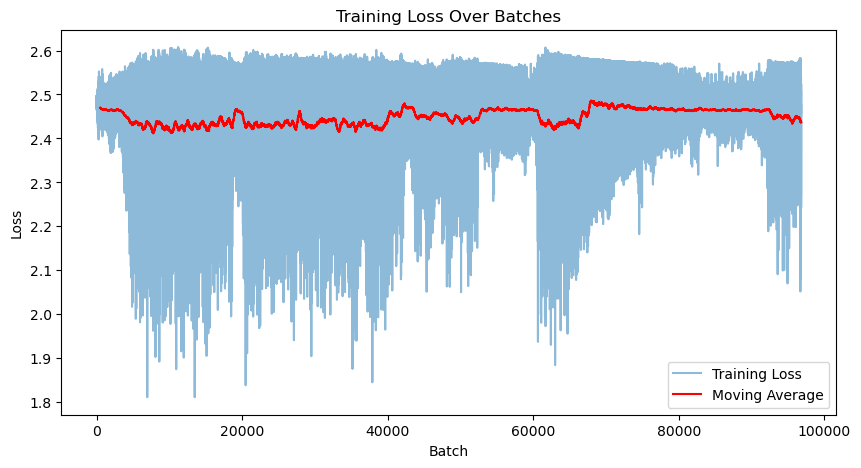

In [21]:
# 绘制原始损失和滑动平均损失
loss_list = loaded_loss_list
window_size = 500
moving_averages = []
for i in range(len(loss_list) - window_size + 1):
    window = loss_list[i : i + window_size]
    window_average = sum(window) / window_size
    moving_averages.append(window_average)

plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Training Loss', alpha=0.5)  # 原始损失，半透明
plt.plot(range(window_size - 1, len(loss_list)), moving_averages, label='Moving Average', color='red')  # 滑动平均，红色线
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Batches')
plt.legend()
plt.show()

## embedding model

In [41]:
from modelscope import snapshot_download
model_dir = snapshot_download("AI-ModelScope/bge-large-zh-v1.5", revision='master', cache_dir='/Users/hayden/Desktop/Hayden/00_project/01_rag/89_wm/tools/models')

from sentence_transformers import SentenceTransformer
model = SentenceTransformer(model_dir)

ModuleNotFoundError: No module named 'modelscope'

In [44]:
embeddings = model.encode(train_data['text'][:3], normalize_embeddings=True)
embeddings

array([[ 0.00111934,  0.00498347,  0.00489536, ..., -0.00393913,
         0.01173168, -0.02182466],
       [-0.01977464,  0.03418102,  0.00971463, ..., -0.0377924 ,
        -0.03815355, -0.04228568],
       [ 0.01309806,  0.01281571, -0.01817187, ...,  0.01497762,
        -0.02367404,  0.00638042]], dtype=float32)

`normalize_embeddings` 参数在 `model.encode` 方法中用于控制是否对生成的嵌入向量进行归一化。具体来说，当 `normalize_embeddings=True` 时，生成的嵌入向量会被归一化为单位向量，即每个向量的模长（L2范数）为1。这在某些应用场景中非常有用，特别是在计算向量之间的相似度时。

- normalize_embeddings=True 使生成的嵌入向量被归一化为单位向量。
- 这在计算向量相似度和聚类等任务中非常有用。
- 通过归一化，可以消除向量长度的影响，使得相似度计算更加依赖于向量的方向。

In [ ]:
# 加载模型
import joblib
model = joblib.load("path_to_model.pkl")  # 替换为您的模型路径

# 输入文本
text = "您的输入文本"

# 文本预处理（根据模型的需求调整）
preprocessed_text = preprocess(text)  # 替换为您的预处理函数

# 预测
prediction = model.predict([preprocessed_text])

# 输出结果
print("预测结果:", prediction)


In [47]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import jieba
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# 预处理函数
def preprocess_text(text, dictionary):
    words = jieba.lcut(text)
    bow = dictionary.doc2bow(words)
    return bow

model = IntentClassifier(input_dim=100, hidden_dim=16, output_dim=12)  # 假设参数
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))
model.eval()

# 加载字典
dictionary_path = r'C:\Users\五行缺钱\PycharmProjects\pythonProject1\NLP\intension recognition\data\dict.txt'
dictionary = Dictionary.load_from_text(dictionary_path)

# 待预测的文本
text_to_predict = "这里是你想要预测的文本"

# 预处理文本
processed_text = preprocess_text(text_to_predict, dictionary)

# 将词袋模型转换为TF-IDF
corpus = [processed_text]
tfidf_model = TfidfModel(corpus)
corpus_tfidf = list(tfidf_model[corpus])

# 将TF-IDF向量转换为模型输入
input_tensor = torch.tensor([v for _, v in corpus_tfidf[0]], dtype=torch.float32).unsqueeze(0)

# 模型预测
with torch.no_grad():
    outputs = model(input_tensor)

# 将输出转换为预测结果
_, predicted_class = torch.max(outputs, 1)

# 输出预测结果
print(f"Predicted class: {predicted_class.item()}")


C:\Users\五行缺钱\AppData\Local\Temp\ipykernel_22604\3183005945.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth', map_location=t

RuntimeError: Error(s) in loading state_dict for IntentClassifier:
	Missing key(s) in state_dict: "fc.0.weight", "fc.0.bias", "fc.2.weight", "fc.2.bias". 
	Unexpected key(s) in state_dict: "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0", "fc.weight", "fc.bias". 